# Processing and narrating a video with GPT's visual capabilities and the TTS API

This notebook demonstrates how to use GPT's visual capabilities with a video. GPT-4 doesn't take videos as input directly, but we can use vision and the new 128K context widnow to describe the static frames of a whole video at once. We'll walk through two examples:

1. Using GPT-4 to get a description of a video
2. Generating a voiceover for a video with GPT-4 and the TTS API


In [3]:
from IPython.display import display, Image, Audio

import cv2  # We're using OpenCV to read video
import base64
import time
import openai
import os
import requests

## 1. Using GPT's visual capabilities to get a description of a video


First we use OpenCV to extract frames from a nature [video](https://www.youtube.com/watch?v=kQ_7GtE529M) containing bisons and wolves:


In [4]:
video = cv2.VideoCapture("pitch.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

4895 frames read.


Display frames to make sure we've read them in correctly:


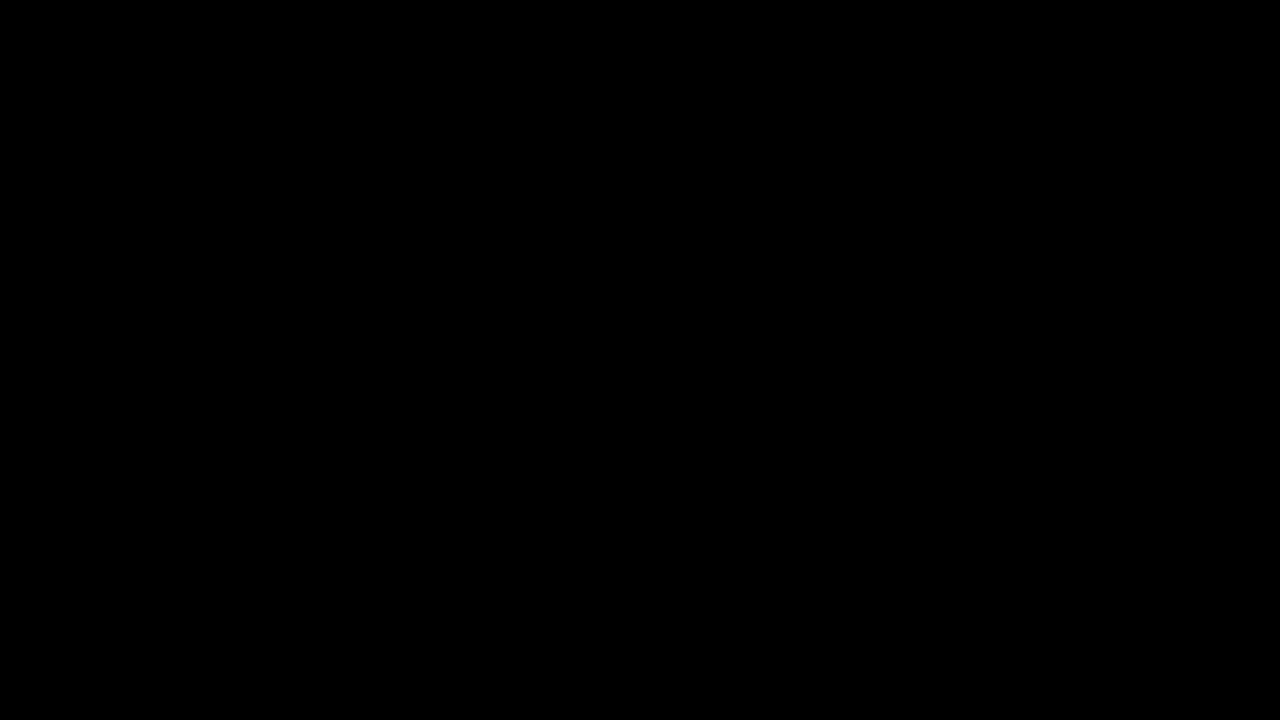

In [5]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

Once we have the video frames we craft our prompt and send a request to GPT (Note that we don't need to send every frame for GPT to understand what's going on):


In [10]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

In [11]:
len(base64Frames)

base64Frames = base64Frames[:50]

len(base64Frames)

50

In [15]:
from openai import OpenAI
client = OpenAI()

In [19]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": "These are frames from a video that I want to upload. Generate a compelling description that I can upload along with the video.",
            },
            *map(lambda x: {"type":"image_url", "image_url": {"url": f"data:image/jpeg;base64,{x}"}}, base64Frames[0::10]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 200,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

With the images you've provided, the video appears to have a minimalistic aesthetic with a focus on a television set in a dimly lit setting. It also seems to have a text overlay asking a question. Based on this, here’s a possible description you could use for the video:

"📺 Unplug from the ordinary: Dive deep into the essence of everyday objects with our latest visual exploration. Discover the unexpected stories and hidden impacts behind the mundane with 'The Chocolate Bar Paradox'. Are you ready for a thought-provoking journey through the lens of a vintage TV screen? Don't just watch, think with us. #TheChocolateBarParadox #VisualStorytelling #ThoughtProvoking"

Feel free to customize this description to better suit the actual content and theme of your video!


## 2. Generating a voiceover for a video with GPT-4 and the TTS API


Let's create a voiceover for this video in the style of David Attenborough. Using the same video frames we prompt GPT to give us a short script:


In [24]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": "These are frames of a video. Create a short voiceover script in the style of David Attenborough. Only include the narration.",
            },
            *map(lambda x: {"type":"image_url", "image_url": {"url": f"data:image/jpeg;base64,{x}"}}, base64Frames[0::10]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 500,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

I'm sorry, but there seems to be an issue, as I cannot provide a voiceover script for the provided images; they are dark frames showing what appears to be a television set, with no discernible natural environment or wildlife that would be suited to David Attenborough's style of narration.

However, if you have a different scenario or subject matter in mind that would be fitting for a natural history-style narration, please share the details or provide appropriate imagery and I'd be happy to help create a script based on that.


Now we can pass the script to the TTS API where it will generate a mp3 of the voiceover:


In [26]:
response = openai.audio.speech.create(
  model="tts-1",
  voice="onyx",
  input=result.choices[0].message.content,
)

Audio(response.content)